# Calcul de la vitesse critique en fonction de $\beta$ et de $\gamma$

In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

Dans ce code on se propose d'étudier l'impact du paramètre de masse: $\beta = \frac{M}{M+m}$ et du paramètre de gravité $\gamma = \frac{g(m+M)L^{3}}{EI}$ sur la vitesse critique $u_{cr}=\sqrt{\frac{M}{EI}}LU_{cr}$   
La vitesse critique est définie comme la vitesse à partir de laquelle apparait le phénomène de flutter, c'est à dire la vitesse à partir de laquelle, pour au moins un mode du tuyau, l'amortissement devient nul puis négatif tout en gardant une fréquence non nulle contrairement au buckling.   
Pour résoudre ce problème on utilise la même méthode que dans le code permettant d'obtenir les modes vibratoire d'un tuyau encastré-libre. La méthode la plus "logique" consisterait à faire augmenter la valeur de pour chaque valeur de $\beta$ et de $\gamma$ et de parcourir les valeurs propres jusqu'à ce que l'amortissement d'un mode s'annule tout en vérifiant que la féquence du mode associé reste non nul et qu'il ne s'agit pas de buckling. Cependant lorsqu'on observe les graphiques tracés dans le livre de Paidoussis on peut voir que pour une valeur de $\beta$ et de $\gamma$ il peut exister deux vitesses critiques. Il semble qu'à certain endroits le système se restabilise avant de présenter à nouveau un phénomène de flutter. Pour détecter ce phénomène nous avons donc décidé de faire varier $\beta$ plutot que u et de donc noter une valeur de "$\beta$ critique" pour chaque couple de u et de $\gamma$.

Ce bloc correspond à l'importation des librairies nécessaires pour la résolution du problème. Ces librairies sont les mêmes que pour le précédent code.

In [2]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as mpl

Ce bloc permet de définir les paramètres du problème ainsi que de sa résolution. Vous pouvez modifier ces paramètres pour observer leur impact sur le résultat. Attention certain paramètres pourraient conduire à une augmentation importante du temps d'exécutions.

In [3]:
L = 0.5  ##Longueur du tuyau
N = 10  ##Nombre de modes de poutre utilisé avec la méthode de Galerkin
array_beta = np.linspace(0,1,101)  ##Tableau des valeurs de beta pour lesquelles on calcul U critique
array_gamma = np.array([-10,0,10,100])  ##Tableau des valeurs de gamma pour lesquelles on calcul U critique
u_array = np.linspace(0,50,501)  
url = "https://raw.githubusercontent.com/MorganDemenois/Pipe-conveying-fluid/main/Images/flutter.PNG"

Ce bloc permet de calculer les valeurs propres d'une poutre encastrée-libre de la même façon que dans le code précédent.

In [4]:
def Eq_Cara(Lambda):
    return np.cos(Lambda)*np.cosh(Lambda)+1

LAMBDA = []

for i in range(N):
    LL_Guess = np.pi*(2*i+1)/2
    x0 = LL_Guess + 0.1
    x1 = LL_Guess - 0.1
    while abs(x0-x1)>10**-16:
        xnew = x0 - (x0-x1)*Eq_Cara(x0)/(Eq_Cara(x0)-Eq_Cara(x1))
        x1 = x0
        x0 = xnew
    LAMBDA.append(x0)

##Affichage des résultats
print()
for i in range(len(LAMBDA)):
    print("Valeur propre du mode "+str(i+1)+" d'une poutre: ")
    print(str(LAMBDA[i])+'\n')


Valeur propre du mode 1 d'une poutre: 
1.8751040687119611

Valeur propre du mode 2 d'une poutre: 
4.694091132974175

Valeur propre du mode 3 d'une poutre: 
7.854757438237613

Valeur propre du mode 4 d'une poutre: 
10.995540734875467

Valeur propre du mode 5 d'une poutre: 
14.13716839104647

Valeur propre du mode 6 d'une poutre: 
17.278759532088237

Valeur propre du mode 7 d'une poutre: 
20.42035225104125

Valeur propre du mode 8 d'une poutre: 
23.561944901806445

Valeur propre du mode 9 d'une poutre: 
26.7035375555183

Valeur propre du mode 10 d'une poutre: 
29.845130209102816



Dans ce bloc on commence par définir les fonctions permetant de calculer les termes $\sigma_r$, $b_{sr}$, $c_{sr}$ et $d_{sr}$ définis précédemment.  
On définit ensuite les matrices B, C, D, $\Delta$ et M.  
Enfin la fonction permettant de calculer les matrices S et K en fonction de u puis de construire par blocs les matrices E et F est définie. Cette fonction utilise ensuite scipy.linalg.eig() pour calculer les vecteurs et valeurs propres du problème de la même façon que dans le code précédent.

In [5]:
def sigma(r):
    return ((np.sinh(L*LAMBDA[r])-np.sin(L*LAMBDA[r]))/(np.cosh(L*LAMBDA[r])+np.cos(L*LAMBDA[r])))

def bsr(s,r):
    if s == r:
        return 2
    else:
        return 4/((LAMBDA[s]/LAMBDA[r])**2+(-1)**(r+s))
    
def csr(s,r):
    if s == r:
        return LAMBDA[r]*sigma(r)*(2-LAMBDA[r]*sigma(r))
    else:
        return 4*(LAMBDA[r]*sigma(r)-LAMBDA[s]*sigma(s))/((-1)**(r+s)-(LAMBDA[s]/LAMBDA[r])**2)
    
def dsr(s,r):
    if s == r:
        return csr(s,r)/2
    else:
        return (4*(LAMBDA[r]*sigma(r)-LAMBDA[s]*sigma(s)+2)*(-1)**(r+s))/(1-(LAMBDA[s]/LAMBDA[r])**4)-((3+(LAMBDA[s]/LAMBDA[r])**4)/(1-((LAMBDA[s]/LAMBDA[r])**4)))*bsr(s,r)                                                                                                                                               

M = np.eye(N)
B = np.zeros((N,N))
C = np.zeros((N,N))
D = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        B[i,j] = bsr(i,j)  
        C[i,j] = csr(i,j)
        D[i,j] = dsr(i,j)   
        
Delta = np.zeros((N,N))
for i in range(N):
    Delta[i,i] = LAMBDA[i]**4

def result(u,beta,gamma):
    S = 2*beta**0.5*u*B
    K = Delta + gamma*B + (u**2-gamma)*C + gamma*D
    F = np.block([[np.zeros((N,N)),M],[M,S]])
    E = np.block([[-M,np.zeros((N,N))],[np.zeros((N,N)),K]])     
    eigenValues, eigenVectors = linalg.eig(-np.dot(np.linalg.inv(F),E))

    return eigenValues, eigenVectors

Ce bloc permet de boucler sur les trois paramètres du problèmes et stocker les valeurs de $\beta$ critique pour chaque couple de u et de $\gamma$. On part de la valeur de $\beta$ maximale puis on diminue puisque le système est plus stable pour de grandes valeurs de $\beta$: On part d'un système et on diminue $\beta$ jusqu'à destabiliser le système et noter $\beta$ critique. Pour détecter l'apparition du flutter on repère le moment où un des modes présente une partie imaginaire de Omega inférieure à 0. Il est important de vérifier que la partie réelle du Omega correspondant à ce mode (fréquence) est bien non nulle est qu'il s'agit bien de flutter et non de buckling. En effet lorsque $\gamma$ est négatif, i.e. que le tuyau est à la vertical alors celui-ci est statiquement instable à u=0 mais il ne s'agit pas de flutter. 

In [6]:
b_critique = np.zeros((len(array_gamma),len(u_array)))


for g in range(len(array_gamma)):  ##Boucle sur les valeurs de gamma
    for i in range(len(u_array)):  ##Boucle sur les valeurs de u
        
        u = u_array[i]
        gamma = array_gamma[g]
        beta = array_beta[-1]
        
        eigenValues, eigenVectors = result(u,beta,gamma)
        
        for b in range(1,len(array_beta)):  ##Boucle sur les valeurs de beta
            
            ##On parcourt la liste beta à l'envers car le système se déstabilise lorsque beta diminue
            beta = array_beta[len(array_beta)-b]   
        
            eigenValues, eigenVectors = result(u,beta,gamma)
            
            ##On cherche le mode correspondant au minimum de la partie imaginaire de Omega: le mode le plus instable
            Arg = np.argmin((-1j*eigenValues).imag)
                
            ##Si le minimum de la partie imaginaire de Omega est inférieur à 0 alors la physique du tuyau est instable
            ##On vérifie que la valeur de b_critique précédent est bien égale à 0 pour stocker la première valeur de béta à partir de laquelle le flutter apparait
            ##On vérifie que la partie réelle de Omega correspondant au mode en question est bien non nulle: on cherche le flutter et non le buckling
            if (-1j*eigenValues).imag[Arg] < -0.01 and b_critique[g,i] == 0 and (-1j*eigenValues).real[Arg] != 0:
                b_critique[g,i] = beta

Ce bloc permet de tracer le diagramme présentant l'évolution de la vitesse critique en fonction de $\beta$ pour 4 valeurs de $\gamma$.

Text(0.5, 1.0, 'Flutter instability')

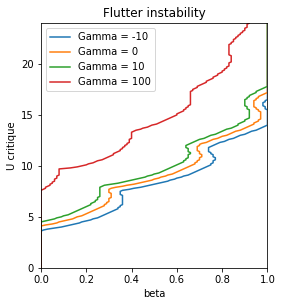

In [7]:
fig = mpl.figure(figsize=(4.5, 4.5))
ax = fig.add_subplot(1, 1, 1, aspect = 0.045)
ax.set_xlim((0,1))
ax.set_ylim((0,24))
ax.plot(b_critique[0,:],u_array,label='Gamma = -10')
ax.plot(b_critique[1,:],u_array,label='Gamma = 0')
ax.plot(b_critique[2,:],u_array,label='Gamma = 10')
ax.plot(b_critique[3,:],u_array,label='Gamma = 100')
ax.legend()
ax.set_xlabel("beta")
ax.set_ylabel("U critique")
ax.set_title("Flutter instability")

Ce bloc permet de tracer le diagramme obtenu par Paidoussis pour le même problème.

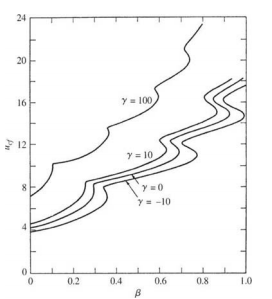

In [8]:
from IPython.display import Image
Image(url)